In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stats
import statsmodels.tsa.stattools as stattools

from orderBook import orderBook

#### Trading mechanism

In a Perpetual Futures market, traders are periodically awarded or penalized by a 'funding rate' based on whether their entry positions are above or below the price of the asset in the spot market at the time of funding (which occurs periodically), and whether they are long or short the position. The mechanism is designed to incentivize traders to 'peg' the perpetual price to the 'spot' price by incentivizing traders to take a short position when the perp price is higher than the spot price, and a long position when the perp price is below the spot price.

For example, a trader who is long BTC at a perp price of `$`40,000 (averaged over the funding period) will recieve the funding rate if the spot price is `$`42,000, at the time of funding. A trader who is short (indeed, the trader who took the opposite side of the long position) will have pay the same funding rate. This funding rate incentivizes traders to bring the price of the perp into sync with the spot price. Since every long position is matched with a short position, the traders are basically paying each other each period, provided they have balances in their accounts. 

Since the funding depends on the spot price data provided exogneously to the perpetual market, to create our simulation, we first need a data-generating process that creates these spot prices.

#### External price data for simulation

We will first simulate this external 'spot' price using a Geometric Brownian Motion (GBM) data-generating process. This is the most commonly used model for simulating stock prices \<will include citation source\>. 

A GBM is a stochastic process governed by the following equation:

$ S_t = S_0 e^{((\mu - \frac{\sigma}{2}) + \sigma W_t )}$

Where:

$t$ : time 

$S_t$ : the price at time $t$

$S_0$ : the price at $t = 0$

$\mu$ : a 'drift' variable representing the trend of the price movement

$\sigma$ : the volatility or variation of the prices (standard deviation). In this formulation, the volatility is constant, which is not very realistic. This will be addressed later.

$W_t$ : a 'weiner process' representing the unpredictability of the prices (here a random walk)

##### Sample Code:

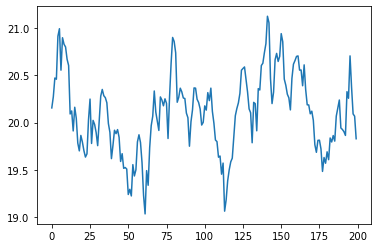

In [2]:
def generateGBM(horizon, dt, mu, sigma, S0):
    # Number of server ticks in horizon
    N = round(horizon/dt)

    # Generate the server ticks as a vector of length N, with interval dt (linspace splits T N times, starting at 0 here)
    t = np.linspace(0, horizon, N)

    # Generate weiner process 
    # Draw N values from normal distribution for increment/decrement at each server tick, 
    W = np.random.standard_normal(size = N) 
    # then sum them cumulatively and scale by sqrt of dt to get random walk
    W = np.cumsum(W)*np.sqrt(dt) 

    # Generate GBM using formula
    return S0*np.exp((mu-0.5*sigma**2)*t + sigma*W)


S = generateGBM(2, 0.01, 0.01, 0.1, 20)

# Plot
plt.plot(S)
plt.show()

#### Agents

The traders in this simulation are based on this paper: Carl Chiarella and Giulia Iori. A simulation analysis of the microstructure of double auction markets. Quantitative Finance, 2:346–353, 2002. 

This is a seminal paper that particularly models [Limit Order Book](https://en.wikipedia.org/wiki/Central_limit_order_book)-based exchanges simply.

In this paper, each trader is modelled *as a composite* of the following types of traders:

- Fundamentalist traders who believe the prices are mean reverting to a 'true price'
- Chartists who use local trends to forecast prices
- Noise traders who place trades randomly

Our model implementation will be based on code by Blake LeBaron from the [agentfin](http://people.brandeis.edu/~blebaron/classes/agentfin/Chiarellaetal.html) website.

##### Sample Agent Code:

In [65]:
class agent:
    
    # Agent constructor
    def __init__(self,sigmaF,sigmaM,sigmaN,kmax,Lmin,Lmax):
        # set strategy weights randomly
        # Fundamentalist weight is always positive
        self.fundWeight =  np.abs(sigmaF*np.random.randn())
        self.chartWeight = (sigmaM*np.random.randn())
        self.noiseWeight = (sigmaN*np.random.randn())
        # random horizon for momentum rules 
        self.l = np.random.randint(Lmin,Lmax)
        # random component of spread
        self.k = kmax*np.random.rand()
        # Initialize forecasts
        self.fcast = 0.
        self.pfcast = 0.
        self.position = 0.
        self.bid = 0.
        self.ask = 0.
        # forecast adjustment weight
        self.fcastAdjust = 1./(self.fundWeight+self.chartWeight+self.noiseWeight)
    
    # Function that forecasts the price for the next funding period.
    def updateFcast(self,forecast,price,t,tau):
        # weighted forecast value
        self.fcast = self.fcastAdjust*(self.fundWeight*forecast.fundamental+self.chartWeight*forecast.chartist[self.l] + self.noiseWeight*forecast.noise)
        # bound the forecast
        self.fcast = min(self.fcast,0.5)
        self.fcast = max(self.fcast,-0.5)
        # exponentiate the forecast to get future price forecast 
        # note:  this could have a variance adjustment, but it doesn't at the moment
        self.pfcast = price*np.exp(self.fcast) + forecast.premiumForecast
        
    def getAgentOrder(self,price):
        # generate bid or ask with k and forecast price
        if self.pfcast > price:
            self.bid = (1.-self.k)*self.pfcast
        else :
            self.ask = (1.+self.k)*self.pfcast

This code only instantiates the agents with a distribution of the weights each trader applies to a trading 'approach', and provides funcions that updates their price forecasts and orders. The actual forecast logic will be detailed below. 

##### Agent instantiation and distribution

In [66]:
# Set number of agents
nAgents = 500
# Default weights for 
# Fundamentalist weight
sigmaF = 1.
# Chartist weight
sigmaM = 1.
# Noise weight
sigmaN = 1.
# horizons for momentum rules - bounds for how far back should they go to estimate trend
Lmin = 5
Lmax = 50
# random component of spread
kMax = 0.5

# holder list for agent objects
agentList = []
for i in range(nAgents):
    agentList.append(agent(sigmaF,sigmaM,sigmaN,kMax,Lmin,Lmax))

fundWeightList = [a.fundWeight for a in agentList]
chartWeightList = [a.chartWeight for a in agentList]
noiseWeightList = [a.noiseWeight for a in agentList]

The agent population thus created has a distribution across the various strategies, with fundamentalist always having a positive weight, whilst chartists and noise traders can be negative as well as positively weighted. This functionality allows us to control the characteristics of the trading population with regard to these trading strategies. The distribution is visualized below, with fundamentalist weights on the x-axis, chartist weights on the y-axis and noise trader weights on the z-axis:

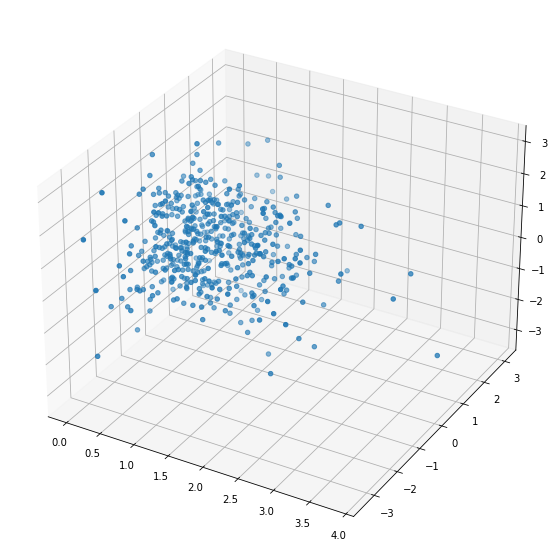

In [67]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(fundWeightList, chartWeightList, noiseWeightList)

##### Price Forecasts

To better understand how agents make trading decisions, let us look at the code for forecast generation. While the original code for traditional stock markets updates the price forecast for the next server tick, the code below updates the price forecast for the *next funding period* which can be many server ticks ahead of the current tick. 

In [68]:
class forecasts:
    # initialize forecast components
    def __init__(self, Lmax, pf, sigmae, fundingRate, fundingDuration):
        self.fundamental = 0.
        # chartist is vector for different lengths
        self.chartist = np.zeros(Lmax)
        self.noise = 0.
        self.premiumForecast = 0.
        self.v = 0.
        self.pf = pf
        self.sigmae = sigmae
        self.Lmax = Lmax
        self.fundingRate = fundingRate
        self.fundingDuration = fundingDuration 

    # update forecasts   
    def updateForecasts(self, t, price, returns, spotPrice, premia):
        # Variance of returns
        self.v = np.var(returns[0:t])
        
        # Price forecasts        
        # The Fundamentalist believes the price reverts to the mean. The return expectation is scaled by the number of ticks until the next funding period
        self.fundamental = np.log(np.mean(spotPrice[0:t])/price)
        
        # The Chartist captures the moving average within a time horizon, and extrapolates the trend
        revrets = returns[t:(t-self.Lmax):-1]
        self.chartist = np.cumsum(revrets)/np.arange(1.,float(self.Lmax+1))
        
        # The noise trader makes random price forecasts
        self.noise = self.sigmae*np.random.randn()
        
        # Premia forecasts 
        # Simple average of premia since a duration equal to the funding period
        #self.premiumForecast = np.mean(premia[(t-self.fundingDuration):t])*self.fundingRate*self.fundingDuration
        self.premiumForecast = premia[t]*self.fundingRate*self.fundingDuration
        

Since all agents use the same machinery to calculate the priceforecasts, but weight them differently, the forecast code is extracted above to be used by all agents. Each agent receives the same forecasts, but weights them differently and adds them together to produce its own forecast.

#### Simulation

First we create the external price signal using GBM with the following parameters:

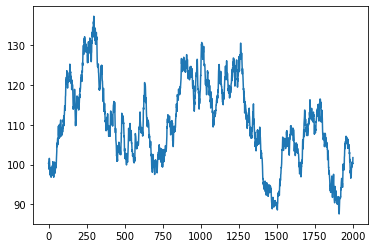

In [69]:
horizon = 20
dt = 0.01
mu = 0.01
sigma = 0.1
startingPrice = 100

spotPrice = generateGBM(horizon, dt, mu, sigma, startingPrice)

plt.plot(spotPrice)
plt.show()

Let's assume the futures market starts at the 250th tick, and the funding period is every 100 ticks.

In [75]:
# Initial and max ticks
tInit = 250
tMax = 2000

# Noise trader sigma
sigmae = 0.01

# Investment horizon (how far ahead in time the traders forecasts prices)
tau = 50
deltaP = 0.1

# Starting price forecast for fundamentalist
pf = 100 #(same as S0 of GBM)

# Funding duration and periods
fundingRate = 0.00025
fundingDuration = 100
fundingPeriods = range(tInit, tMax, fundingDuration)

# perp & spot prices, returns, and premia
perpPrice = pf*np.ones(tMax)
perpPrice[(tInit - fundingDuration):tInit] = spotPrice[(tInit - fundingDuration):tInit]
perpReturns   = np.ones(tMax)
premia = perpPrice - spotPrice
totalV = np.zeros(tMax)

# Initialize Forecasts
forecastSet = forecasts(Lmax, pf, sigmae, fundingRate, fundingDuration)

# create order book
marketBook = orderBook(0.,500.,deltaP)

for t in range(tInit, tInit + 10):
    #next funding period
    #nextFundingt = min([x for x in fundingPeriods if x > t])
    tradePrice = -1
    
    #update forecasts
    forecastSet.updateForecasts(t, perpPrice[t], perpReturns, spotPrice, premia)
    
    #pick a random trader
    randomAgent = agentList[np.random.randint(1,nAgents)]
    
    #update agent's forecast
    randomAgent.updateFcast(forecastSet, perpPrice[t], t, 1)
    
    # get demands for random agent
    randomAgent.getAgentOrder(perpPrice[t])
        
    # potential buyer
    if randomAgent.pfcast > perpPrice[t]:
        # add bid or market order 
        tradePrice = marketBook.addBid(randomAgent.bid,1.,t)
    else:
        # seller: add ask, or market order
        tradePrice = marketBook.addAsk(randomAgent.ask,1.,t)
    
    # update price and volume
    # no trade
    if tradePrice == -1:
        perpPrice[t+1]=(marketBook.bestBid + marketBook.bestAsk)/2.
        totalV[t+1]=totalV[t]
    else:
        # trade
        perpPrice[t+1] = tradePrice
        totalV[t+1] = totalV[t]+1.
    
    # returns
    perpReturns[t+1]=np.log(perpPrice[t+1]/perpPrice[t])
    
    # premia update
    premia[t+1] = perpPrice[t+1] - spotPrice[t+1]
    
    #DEBUG
    print("Spot price: ", spotPrice[t])
    print("Perp price: ", perpPrice[t])
    print("Premium: ", premia[t])
    print(" ")
    print("Fundamentalist: ", forecastSet.fundamental)
    print("Chartist: ", forecastSet.chartist[randomAgent.l])
    print("Noise: ", forecastSet.noise)
    print("Premium: ", forecastSet.premiumForecast)
    print(" ")
    print("Agent K: ", randomAgent.k)
    print("Agent Fcast: ", randomAgent.fcast)
    print("Agent Forecast: ", randomAgent.pfcast)
    print("Best Bid: ", marketBook.bestBid)
    print("Best Ask: ", marketBook.bestAsk)
    print(" ")
    
    # clear book
    if(rnd.rand()<0.2):
        marketBook.cleanBook(t,tau)

Spot price:  128.78650448402587
Perp price:  100.0
Premium:  -28.78650448402587
 
Fundamentalist:  0.12615035598086582
Chartist:  1.0
Noise:  0.025876668916305336
Premium:  -0.7196626121006467
 
Agent K:  0.14406505525587998
Agent Fcast:  0.2802204482706695
Agent Forecast:  131.62249000481552
Best Bid:  249.9
Best Ask:  250.10000000000002
 
Spot price:  129.0569317343269
Perp price:  250.0
Premium:  120.9430682656731
 
Fundamentalist:  -0.7896017550683804
Chartist:  0.997463355511338
Noise:  -0.005602794197031389
Premium:  3.0235767066418275
 
Agent K:  0.4749637395088909
Agent Fcast:  -0.5
Agent Forecast:  154.65624163480018
Best Bid:  249.9
Best Ask:  250.10000000000002
 
Spot price:  129.49747258752498
Perp price:  249.9
Premium:  120.40252741247502
 
Fundamentalist:  -0.7886581662928046
Chartist:  0.9483757453263246
Noise:  0.00918140226767311
Premium:  3.0100631853118753
 
Agent K:  0.3927599994555666
Agent Fcast:  0.5
Agent Forecast:  415.0255087332739
Best Bid:  249.9
Best Ask: 